In [185]:
# Imports
import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import stockDataHandler as sdh
from tqdm import notebook
import seaborn as sns

import importlib
import msciLib
importlib.reload(msciLib)

<module 'msciLib' from '/Users/melissawilson/git/msci_ml/workspace/msciLib.py'>

In [186]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras import metrics
import seaborn as sns
import matplotlib.pyplot as plt
from keras import backend as K
from keras.wrappers.scikit_learn import KerasRegressor

In [187]:
# Flags 
graph = False

# Seeds
import random
random.seed(42)
from numpy.random import seed
seed(42)
import tensorflow
tensorflow.random.set_seed(3)

# Make Training and Test Indicies

Matrix has data from 1827 tickers and each ticker has 5 of its features included, excluding the 6th OpenInt.  

In [188]:
# Load clean matrix and tickers
matrix_3201 = np.load("matrix_3201.npy")
tickers_3201 = np.load("tickers_3201.npy")

In [189]:
# Print the shape of each loaded item.
print(matrix_3201.shape)
print(tickers_3201.shape)
bound_value = matrix_3201.shape[0] # number of examples

(3201, 9135)
(1827,)


In [190]:
# Shuffle dataset.
shuffled_indicies = np.linspace(0, bound_value - 1, bound_value, dtype=int)
np.random.seed(42)
np.random.shuffle(shuffled_indicies)

In [191]:
# Train and test indicies
train_indicies = shuffled_indicies[:int(shuffled_indicies.size * 0.50)]
test_indicies = shuffled_indicies[int(shuffled_indicies.size * 0.50):]

In [192]:
# Size and shape of Datasets
print(len(train_indicies))
print(len(test_indicies))
print(matrix_3201.shape)

1600
1601
(3201, 9135)


# Plot 'close' for 3 Random Tickers

In [193]:
# Grab three random tickers
ticker_index1, ticker_index2, ticker_index3 = random.sample(range(0, len(tickers_3201)), 3)
print("The three tickers chosen: {}, {}, {}".format(
    tickers_3201[ticker_index1], tickers_3201[ticker_index2], tickers_3201[ticker_index3]))

The three tickers chosen: plab, bwa, ajrd


In [194]:
sns.set_style("darkgrid")

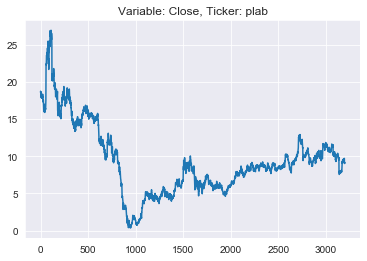

In [195]:
msciLib.plot_ticker(matrix_3201, tickers_3201, ticker_index1, "Close")

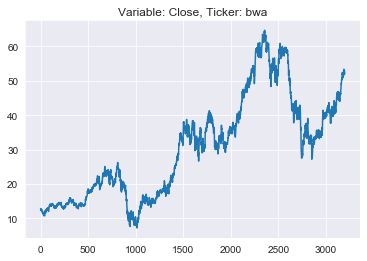

In [196]:
msciLib.plot_ticker(matrix_3201, tickers_3201, ticker_index2, "Close")

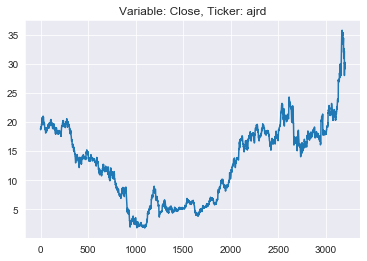

In [197]:
msciLib.plot_ticker(matrix_3201, tickers_3201, ticker_index3, "Close")

# Training of different models.

## Training for first random ticker 'plab'

In [198]:
# Delete close for given ticker.
train_set = np.delete(matrix_3201[train_indicies], ticker_index1 * 5 + 3, 1)
train_target = matrix_3201[train_indicies][:, ticker_index1 * 5 + 3]
test_set = np.delete(matrix_3201[test_indicies], ticker_index1 * 5 + 3, 1)
test_target = matrix_3201[test_indicies][:, ticker_index1 * 5 + 3]

In [199]:
# Shape of the sets
print(train_set.shape)
print(train_target.shape)
print(test_set.shape)
print(test_target.shape)

(1600, 9134)
(1600,)
(1601, 9134)
(1601,)


In [200]:
def create_model():
    # create model
    model = Sequential()
    model.add(Dense(10, input_dim=train_set.shape[1], activation='relu'))
    model.add(Dense(50, activation='sigmoid'))
    model.add(Dense(40, activation='relu'))
    # model.add(Dense(25, activation='relu'))
    model.add(Dense(1))
    # Compile model
    model.compile(optimizer ='adam', loss = 'mean_absolute_percentage_error', 
              metrics =[metrics.mape])
    return model

In [201]:
model = create_model()
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_17 (Dense)             (None, 10)                91350     
_________________________________________________________________
dense_18 (Dense)             (None, 50)                550       
_________________________________________________________________
dense_19 (Dense)             (None, 40)                2040      
_________________________________________________________________
dense_20 (Dense)             (None, 1)                 41        
Total params: 93,981
Trainable params: 93,981
Non-trainable params: 0
_________________________________________________________________


In [202]:
history = model.fit(train_set, train_target, validation_data=(test_set, test_target), epochs=50, batch_size=32)

Train on 1600 samples, validate on 1601 samples
Epoch 1/50
1600/1600 [==============================] - 0s 275us/step - loss: 75.5025 - mean_absolute_percentage_error: 75.5025 - val_loss: 57.8107 - val_mean_absolute_percentage_error: 57.8107
Epoch 2/50
1600/1600 [==============================] - 0s 181us/step - loss: 58.7455 - mean_absolute_percentage_error: 58.7455 - val_loss: 55.5231 - val_mean_absolute_percentage_error: 55.5231
Epoch 3/50
1600/1600 [==============================] - 0s 140us/step - loss: 55.9490 - mean_absolute_percentage_error: 55.9490 - val_loss: 53.2527 - val_mean_absolute_percentage_error: 53.2527
Epoch 4/50
1600/1600 [==============================] - 0s 176us/step - loss: 53.6968 - mean_absolute_percentage_error: 53.6968 - val_loss: 50.8188 - val_mean_absolute_percentage_error: 50.8189
Epoch 5/50
1600/1600 [==============================] - 0s 153us/step - loss: 51.0807 - mean_absolute_percentage_error: 51.0807 - val_loss: 48.6205 - val_mean_absolute_percenta

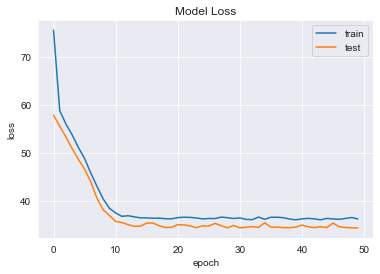

In [206]:
plt.plot(history.history['mean_absolute_percentage_error'])
plt.plot(history.history['val_mean_absolute_percentage_error'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
#plt.ylim(20, 2000)
#plt.xlim(10,)
plt.show()

In [207]:
prediction = model.predict(test_set)

ordered_target = np.full(bound_value, -1)
ordered_pred = np.full(bound_value, -1)

for i in np.arange(len(test_indicies)):
    
    ordered_target[test_indicies[i]] = test_target[i]
    ordered_pred[test_indicies[i]] = prediction[i]

(-1, 3365.782562147697)

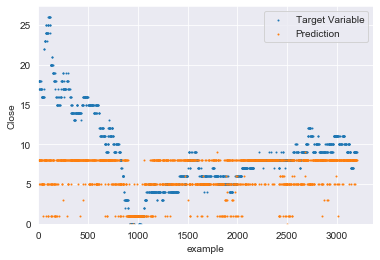

In [208]:
plt.scatter(np.arange(bound_value), ordered_target, s = 1)
plt.scatter(np.arange(bound_value), ordered_pred, s = 1)

# plt.plot(ordered_target, linewidth = 1)
# plt.plot(ordered_pred, linewidth = 1)

plt.ylabel('Close')
plt.xlabel('example')
plt.legend(['Target Variable', 'Prediction'], loc='upper right')

plt.ylim(0, )
plt.xlim(-1,)

1601

0

3199